In [1]:
from copy import deepcopy
import tqdm.notebook

import jax.numpy as jnp
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch

from adaptive_mcmc.distributions.distribution import (
    GaussianMixture,
    FunnelDistribution,
    Gaussian,
    BananaDistribution,
)
from adaptive_mcmc.samplers import (
    base_sampler,
    mala,
    fishermala,
    hmc,
    hmcadaptive,
)
from adaptive_mcmc.samplers.stopping_rule import NoStop
from adaptive_mcmc.tools.benchmark import BenchmarkUtils
from adaptive_mcmc.tools.metrics import compute_ess, compute_emd

from typing import Tuple, Optional

2025-05-24 01:27:19.662624: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748039239.672943   28353 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748039239.676085   28353 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
seed = 123
torch.manual_seed(seed)

device = "cpu"

hparams = {
    "mala": {
        "common": mala.MALACommonParams(
            sigma=1e0,
            sigma_lr=1e-2,    
        ),
    },
    # "fisher_mala": {
    #     "common": fishermala.FisherMALACommonParams(
    #         dampening=100,
    #         sigma=1e0,
    #         sigma_lr=1e-2,
    #     ),
    # },
    "hmc_vanilla": {
        "common": hmc.HMCCommonParams(
            lf_step_count=50,
            lf_step_size=1e-1,
            lf_step_size_max=5e-1,
        ),
        "fixed": hmc.HMCFixedParams(no_grad=True, stop_grad=False),
    },
    "taylor_nograd": {
        "common": hmcadaptive.HMCAdaptiveCommonParams(
            lf_step_count=50,
            lf_step_size=1e-1,
            lf_step_size_max=5e-1,
            learning_rate=3e-4,
            truncation_level_prob=0.5,
            min_truncation_level=2,
            entropy_weight=1e-1,
            entropy_weight_min=1e-3,
            entropy_weight_max=1e2,
            penalty_weight_max=1e1,
            penalty_weight=1e-3,
            penalty_weight_adaptive_rate=1e-3,
            clip_grad_value=1e1,
        ),
        "fixed": hmcadaptive.HMCAdaptiveFixedParams(
            prec_init_scale=1e-9,
            no_grad=True,
            stop_grad=False,
            backprop_method="approx",
            prec_type="tridiag",
            # iter_count=10000,
            # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
        ),
    },
    "lanczos_nograd": {
        "common": hmcadaptive.HMCAdaptiveCommonParams(
            lf_step_count=50,
            lf_step_size=1e-1,
            lf_step_size_max=5e-1,
            learning_rate=3e-4,
            entropy_weight=1e-1,
            entropy_weight_min=1e-3,
            entropy_weight_max=1e2,
            clip_grad_value=1e1,
            lanczos_steps=8,
            krylov_probe_vectors=1,
            # iter_count=10000,
            # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
        ),
        "fixed": hmcadaptive.HMCAdaptiveFixedParams(
            prec_init_scale=1e-9,
            no_grad=True,
            stop_grad=False,
            backprop_method="approx",
            prec_type="tridiag",
            trace_method=hmcadaptive.TraceMethod.HUTCH_LANCZOS,
            # iter_count=10000,
            # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
        ),
    },
    # "hmcadaptive_hutch_taylor": {
    #     "common": hmcadaptive.HMCAdaptiveCommonParams(
    #         lf_step_count=25,
    #         lf_step_size=0.1,
    #         learning_rate=1e-3,
    #         truncation_level_prob=0.5,
    #         min_truncation_level=2,
    #         entropy_weight=1e-1,
    #         entropy_weight_min=1e-3,
    #         entropy_weight_max=1e2,
    #         penalty_weight_max=1e1,
    #         penalty_weight=1e-3,
    #         penalty_weight_adaptive_rate=1e-3,
    #         clip_grad_value=1e1,
    #     ),
    #     "fixed": hmcadaptive.HMCAdaptiveFixedParams(
    #         prec_init_scale=1e-1,
    #         no_grad=False,
    #         stop_grad=False,
    #         prec_type="tridiag",
    #         # iter_count=10000,
    #         # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
    #     ),
    # },
    # "hmcadaptive_hutch_lanczos": hmcadaptive.HMCAdaptiveParams(
    #     lf_step_count=5,
    #     lf_step_size=0.1,
    #     learning_rate=1e-2,
    #     entropy_weight=1e-1,
    #     entropy_weight_min=1e-3,
    #     entropy_weight_max=1e2,
    #     clip_grad_value=1e6,
    #     prec_init_scale=1e0,
    #     trace_method=hmcadaptive.TraceMethod.HUTCH_LANCZOS,
    #     lanczos_steps=4,
    #     krylov_probe_vectors=1,
    #     # iter_count=10000,
    #     # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
    # ),
    # "hmcadaptive_noent": hmcadaptive.HMCAdaptiveParams(
    #     lf_step_count=5,
    #     lf_step_size=0.1,
    #     learning_rate=1e-4,
    #     clip_grad_value=1e6,
    #     prec_init_scale=1e0,
    #     entropy_method="none",
    #     # iter_count=10000,
    #     # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
    # ),
    # "hmcadaptive_fullent": hmcadaptive.HMCAdaptiveParams(
    #     lf_step_count=5,
    #     lf_step_size=0.1,
    #     learning_rate=1e-2,
    #     entropy_weight=1e-1,
    #     entropy_weight_min=1e-3,
    #     entropy_weight_max=1e2,
    #     clip_grad_value=1e6,
    #     prec_init_scale=1e0,
    #     trace_method=hmcadaptive.TraceMethod.HUTCH_LANCZOS,
    #     lanczos_steps=4,
    #     krylov_probe_vectors=1,
    #     entropy_method="full",
    #     # iter_count=10000,
    #     # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
    # ),
}

In [3]:
def get_random_GM(
    gaussian_count: int,
    dimension: int,
    cube: float,
    eps: float=5e-1,
    scale: float=5.,
):
    true_means = torch.rand((gaussian_count, dimension)) * cube - cube / 2
    scales = torch.rand((gaussian_count, dimension)) * scale

    while True:
        try:
            true_covs = torch.rand((gaussian_count, dimension, dimension))
            true_covs, _ = torch.linalg.qr(true_covs)
        
            true_covs = (
                true_covs @ torch.diag_embed(scales) @ true_covs.permute(0, 2, 1) 
                + eps * torch.eye(dimension).unsqueeze(0)
            )
            
            # true_covs = (
            #     true_covs @ true_covs.permute(0, 2, 1) +
            #     torch.eye(dimension).repeat(gaussian_count, 1, 1)
            # )
        
            gm = GaussianMixture(
                true_means,
                true_covs,
                torch.full((gaussian_count,), 1/gaussian_count, dtype=torch.float64)
            )
            break
        except ValueError:
            pass
            
    return gm, true_means

In [4]:
def get_random_GM(
    gaussian_count: int,
    dimension: int,
    cube: float,
    eps: float = 5e-1,
    scale: float = 1.0,
    *,
    seed: Optional[int] = None,
    device: torch.device | str = "cpu",
    dtype: torch.dtype = torch.float32,
) -> Tuple[GaussianMixture, torch.Tensor]:
    """
    Create a reproducible random Gaussian Mixture.

    Parameters
    ----------
    gaussian_count : int      # number of components
    dimension      : int      # dimensionality
    cube           : float    # component means ∈ (-cube/2, cube/2)
    eps            : float    # ε·I added to each covariance
    scale          : float    # upper–bound on random eigen-scales
    seed           : int|None # RNG seed for reproducibility
    device         : str|torch.device
    dtype          : torch.dtype

    Returns
    -------
    gm          : GaussianMixture
    true_means  : Tensor (gaussian_count, dimension)
    """
    g = torch.Generator(device=device)
    if seed is not None:
        g.manual_seed(seed)

    true_means = (
        torch.rand((gaussian_count, dimension), generator=g, device=device, dtype=dtype)
        * cube - cube/2
    )

    scales = torch.rand((gaussian_count, dimension), generator=g, device=device, dtype=dtype) * scale

    while True:
        try:
            # Q = torch.rand((gaussian_count, dimension, dimension), generator=g, device=device, dtype=dtype)
            # Q, _ = torch.linalg.qr(Q)
            Q_list = []
            for _ in range(gaussian_count):
                q = torch.randn((dimension, dimension), generator=g, device=device, dtype=dtype)
                q, _ = torch.linalg.qr(q)
                Q_list.append(q)
            
            Q = torch.stack(Q_list, dim=0)  # shape: (gaussian_count, dimension, dimension)


            true_covs = (
                Q @ torch.diag_embed(scales) @ Q.transpose(-1, -2)
                + eps * torch.eye(dimension, device=device, dtype=dtype).unsqueeze(0)
            )

            gm = GaussianMixture(
                true_means,
                true_covs,
                torch.full((gaussian_count,), 1.0 / gaussian_count, device=device, dtype=dtype),
            )
            break
        except ValueError:
            continue

    return gm, true_means

In [5]:
def generate_simplex(d: int) -> torch.Tensor:
    I = torch.eye(d)
    
    ones = torch.ones((d, d)) / (d+1)
    v1d = I - ones
    vdp1 = -torch.ones((1, d)) / (d+1)
    return torch.cat([v1d, vdp1], dim=0)


def get_toeplitz_GM(dimension: int, cube: float, rho: float=0.99, sigma: float=1.):
    true_means = generate_simplex(dimension) * cube

    inds = torch.arange(dimension)
    power = torch.abs(inds.unsqueeze(0) - inds.unsqueeze(1))

    true_covs = sigma ** 2 * rho ** power
    true_covs = true_covs.repeat(dimension + 1, 1, 1)

    gm = GaussianMixture(
        true_means,
        true_covs,
        torch.ones(dimension + 1) / (dimension + 1)
    )

    return gm, true_means


def get_toeplitz_gaussian(dimension: int,
                          mean: float = None,
                          rho: float = 0.99,
                          sigma: float = 1.0) -> tuple:
    if mean is None:
        mean = torch.zeros(dimension)
        
    inds = torch.arange(dimension)
    power = torch.abs(inds.unsqueeze(0) - inds.unsqueeze(1))
    cov = (sigma ** 2) * (rho ** power)
    
    return Gaussian(mean=mean, cov=cov), mean.unsqueeze(0)


def get_illcond_gaussian(dimension: int,
                         mean: float = None,
                         min_v: float = 1e-2,
                         max_v: float = 1e2) -> tuple:
    if mean is None:
        mean = torch.zeros(dimension)
    elif isinstance(mean, (float, int)):
        mean = torch.full((dimension,), float(mean))
    else:
        mean = torch.tensor(mean, dtype=torch.float32)

    # Create log-spaced eigenvalues (ill-conditioned spectrum)
    eigvals = torch.logspace(torch.log10(torch.tensor(min_v)), 
                             torch.log10(torch.tensor(max_v)), 
                             steps=dimension)

    # Construct diagonal covariance matrix
    cov = torch.diag(eigvals)

    return Gaussian(mean=mean, cov=cov), mean.unsqueeze(0)
    

def sample_se_covariance_torch(dimension, scale=4., noise=0.01, seed=None, device='cpu'):
    if seed is not None:
        torch.manual_seed(seed)

    x = torch.linspace(0, scale, dimension)

    x1 = x.unsqueeze(1)
    x2 = x.unsqueeze(0)
    dist_squared = (x1 - x2) ** 2

    K = torch.exp(-0.5 * dist_squared / (0.1 * scale**2))

    K += noise * torch.eye(dimension, device=device)

    return x, K
    
def get_deterministic_gaussian_se(dimension: int,
                                  mean: float = None,) -> tuple:
    if mean is None:
        mean = torch.zeros(dimension)
        
    _, cov = sample_se_covariance_torch(dimension)
    
    return Gaussian(mean=mean, cov=cov), mean.unsqueeze(0)

def get_banana(dimension: int, b: float = 2.):
    mean = torch.zeros(dimension)
    return BananaDistribution(dimension, b), mean.unsqueeze(0)

In [6]:
# dist = FunnelDistribution(32, scale=3)

#dist, _ = get_toeplitz_gaussian(256, rho=0.95)
# dist, _ = get_deterministic_gaussian_se(32)
#dist, _ = get_illcond_gaussian(128)
dist, _ = get_banana(32, b=10.)

# dist, _ = get_random_GM(gaussian_count=25, dimension=32, cube=2., scale=2.,)
# dist, _ = get_toeplitz_GM(dimension=32, cube=2., rho=0.9)


samples = dist.sample(5000).detach().numpy()

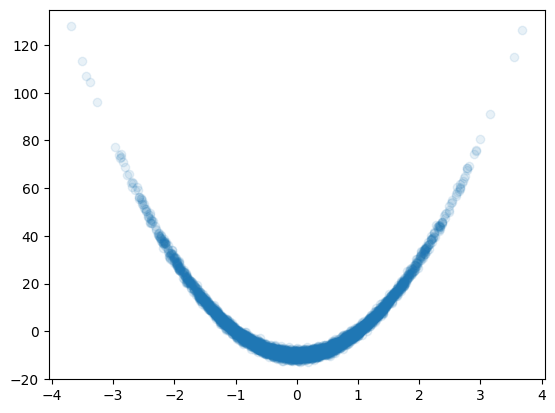

In [7]:
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1)

In [8]:
def dist_factory(name, dimension, cube=2., scale=2., funnel_scale=3, gaussian_count=25, rho=0.95, sigma=1.,
                 min_v=1e-3, max_v=1e3, bending=10.
                ):
    if name == "random_gm":
        return get_random_GM(gaussian_count=gaussian_count, dimension=dimension, cube=cube, scale=scale)
    elif name == "toeplitz_gm":
        return get_toeplitz_GM(dimension, cube=cube, rho=rho, sigma=sigma)
    elif name == "toeplitz_gaussian":
        return get_toeplitz_gaussian(dimension, rho=rho, sigma=sigma)
    elif name == "deterministic_gaussian_se":
        return get_deterministic_gaussian_se(dimension)
    elif name == "funnel":
        return FunnelDistribution(dimension, scale=funnel_scale), torch.zeros(1, dimension)
    elif name == "illcond_gaussian":
        return get_illcond_gaussian(dimension, min_v=min_v, max_v=max_v)
    elif name == "banana":
        return get_banana(dimension, b=bending)

In [9]:
import pandas as pd
from scipy.stats import norm
from itertools import combinations


def drop_static_chains(samples: torch.Tensor, eps: float = 0.0):
    var_per_chain = samples.var(dim=0, unbiased=False)

    static = (var_per_chain <= eps).all(dim=-1)
    keep_mask = ~static

    return samples[:, keep_mask, :], keep_mask.sum().item()


def z_test(dim_stat):
    all_results = {}
    for dim, df in dim_stat.items():
        recs = []
        algs = df.columns
        for A, B in combinations(reversed(algs), 2):
    
            mA, sA = df.loc['ess_mean', A], df.loc['ess_conf_sigma', A]
            mB, sB = df.loc['ess_mean', B], df.loc['ess_conf_sigma', B]
            z_ess = (mA - mB) / (sA**2 + sB**2)**0.5
            p_ess = norm.sf(z_ess)
    
            tA, seA = df.loc['tv_mean', A], df.loc['tv_conf_sigma', A]
            tB, seB = df.loc['tv_mean', B], df.loc['tv_conf_sigma', B]
            z_tv = (tB - tA) / (seA**2 + seB**2)**0.5
            p_tv = norm.sf(z_tv)
            recs.append({
                'alg_A': A, 'alg_B': B,
                'z(ESS_A>B)': z_ess, 'p(ESS_A>B)': p_ess,
                'z(TV_A<B)': z_tv,  'p(TV_A<B)': p_tv,
            })
        all_results[dim] = pd.DataFrame.from_records(recs)
    return all_results


def compute_results(hist_data, algs, dist_name=None):
    dim_stat = {}

    for dimension in tqdm.notebook.tqdm(dimensions, desc="dimension"):
        rows = []
        for alg in tqdm.notebook.tqdm(algs, desc="alg", leave=False):
            obj = hist_data[dimension][alg]
            cache = obj["cache"]
            pure_runtime = obj["pure_runtime"]
    
            clean_samples, n_kept = drop_static_chains(cache.samples)
    
            metrics = BenchmarkUtils.compute_metrics(clean_samples,
                                                     cache.true_samples)
            metrics["runtime"]      = pure_runtime
            metrics["chains_kept"]  = n_kept
            rows.append(metrics)
    
        df = pd.DataFrame(rows, index=list(algs.keys())).T
        dim_stat[dimension] = df
        print(f"\ndim={dimension}, dist={dist_name}\n", df)
        print(z_test(dim_stat))
    
    return dim_stat

In [10]:
def run_experiment(dist_name, log=[]):
    hist_data = {}
    runtime = {
        dimension: dict()
        for dimension in dimensions
    }
    pure_runtime = deepcopy(runtime)
    distance_to_mass_points = 1.
    
    for dimension in tqdm.notebook.tqdm(dimensions):
        print("Processing dimension", dimension)
        hist_data[dimension] = {}
        target_dist, true_means = dist_factory(dist_name, dimension)
        
        # target_dist, true_means = get_random_GM(gaussian_count, dimension, cube)
        # gm, true_means = get_deterministic_GM(dimension, cube)
        # true_samples = gm.sample(sample_count)
    
        # target_dist = FunnelDistribution(dimension, scale=scale)
        
        # target_dist, _ = get_deterministic_gaussian(dimension, rho=0.8)
        # target_dist, _ = get_deterministic_gaussian_se(dimension)
    
        # true_means = torch.zeros(1, dimension)
        true_samples = target_dist.sample(sample_count)
        
        starting_points = BenchmarkUtils.generate_starting_points(
            chain_count, dimension,
            true_means,
            distance_to_mass_points,
        )
    
        common_params = base_sampler.CommonParams(
            target_dist=target_dist,
            starting_point=starting_points.clone(),
            proposal_dist=torch.distributions.MultivariateNormal(
                torch.zeros(dimension, device=device),
                torch.eye(dimension, device=device),
            ),
        )
    
        for alg in algs:
            print("-" * 80)
            base_meta_adj = hparams[alg]["common"].copy_update(common_params)
            # if hasattr(base_meta_adj, "sigma"):
            #     base_meta_adj.sigma /= dimension
    
            algs[alg].load_params(base_meta_adj)
            algs[alg].load_true_samples(true_samples)
            algs[alg].run()
    
            hist_data[dimension][alg] = {
                "cache": algs[alg].pipeline.sample_blocks[-1].iteration.cache,
                "stop_data_hist": algs[alg].pipeline.sample_blocks[-1].stop_data_hist,
                "runtime": algs[alg].pipeline.runtime,
                "pure_runtime": algs[alg].pipeline.pure_runtime,
            }
        print()

    dim_stat = compute_results(hist_data, algs, dist_name)
    log.append({
        "hist_data": hist_data,
        "algs": algs,
        "dist_name": dist_name,
        "dim_stat": dim_stat,
    })

In [11]:
def moving_average(x, window_size=10):
    return np.convolve(x, np.ones(window_size)/window_size, mode='valid')

def print_log(log):
    for entry in log:
        for dimension in dimensions:
            print(f"\ndim={dimension}, dist={entry['dist_name']}\n", entry["dim_stat"][dimension])

In [12]:
chain_count = 30
sample_count = 5000
sample_iter_limit = 5000
burn_in_iter_count = 5000
step_size_burn_in_iter_count = 2500
probe_period = 250000

tv_threshold = 0.05
tail_count_cap = 1000
# stopping_rule = TVStop(threshold=tv_threshold, density_probe_count=1000,
#                        projection_count=25, tail_count_cap=tail_count_cap)

stopping_rule = NoStop(
    density_probe_count=500,
    projection_count=25,
    tail_count_cap=tail_count_cap,
)


dist_names = [
    # "toeplitz_gm",
    # "toeplitz_gaussian",
    "funnel",
    "random_gm",
    "illcond_gaussian",
    "banana",
]

dimensions = [8, 16, 32, 64, 128, 256]
log = []

for dist_name in dist_names:
    algs = {
        "mala": mala.MALAVanilla(
            pipeline=None,
            name="MALA",
            sigma_burn_in_params=hparams["mala"]["common"].copy(),
            sigma_burn_in_iter_count=burn_in_iter_count + step_size_burn_in_iter_count,
            sample_iter_count=sample_iter_limit,
            stopping_rule=stopping_rule,
            probe_period=probe_period,
        ),
        # "fisher_mala": fishermala.FisherMALAVanilla(
        #     pipeline=None,
        #     name="FisherMALA",
        #     sigma_burn_in_iter_count=step_size_burn_in_iter_count,
        #     #common_params=hparams["fisher_mala"]["common"].copy(),
        #     #fixed_params=hparams["fisher_mala"]["fixed"],
        #     prec_burn_in_iter_count=burn_in_iter_count,
        #     sample_iter_count=sample_iter_limit,
        #     stopping_rule=stopping_rule,
        #     probe_period=probe_period,
        # ),
        "hmc_vanilla": hmc.HMCVanilla(
            pipeline=None,
            name="HMCVanilla",
            common_params=hparams["hmc_vanilla"]["common"].copy(),
            fixed_params=hparams["hmc_vanilla"]["fixed"],
            step_size_burn_in_iter_count=step_size_burn_in_iter_count,
            sample_iter_count=sample_iter_limit,
            burn_in_iter_count=burn_in_iter_count,
            stopping_rule=stopping_rule,
            probe_period=probe_period,
            mask_adapt_step_size_required=[False, False, False],
        ),
        "taylor_nograd": hmcadaptive.HMCAdaptive(
            pipeline=None,
            name="HMCAdaptiveHutchTaylorNoGrad",
            common_params=hparams["taylor_nograd"]["common"].copy(),
            fixed_params=hparams["taylor_nograd"]["fixed"],
            step_size_burn_in_iter_count=step_size_burn_in_iter_count,
            sample_iter_count=sample_iter_limit,
            burn_in_iter_count=burn_in_iter_count,
            stopping_rule=stopping_rule,
            probe_period=probe_period,
            mask_adapt_step_size_required=[False, False, False],
        ),
        "lanczos_nograd": hmcadaptive.HMCAdaptive(
            pipeline=None,
            name="HMCAdaptiveHutchLanczosNoGrad",
            common_params=hparams["lanczos_nograd"]["common"].copy(),
            fixed_params=hparams["lanczos_nograd"]["fixed"],
            step_size_burn_in_iter_count=step_size_burn_in_iter_count,
            sample_iter_count=sample_iter_limit,
            burn_in_iter_count=burn_in_iter_count,
            stopping_rule=stopping_rule,
            probe_period=probe_period,
            mask_adapt_step_size_required=[False, False, False],
        ),
        # "hmcadaptive_hutch_taylor": hmcadaptive.HMCAdaptive(
        #     pipeline=None,
        #     name="HMCAdaptiveHutchTaylor",
        #     common_params=hparams["hmcadaptive_hutch_taylor"]["common"].copy(),
        #     fixed_params=hparams["hmcadaptive_hutch_taylor"]["fixed"],
        #     step_size_burn_in_iter_count=step_size_burn_in_iter_count,
        #     sample_iter_count=sample_iter_limit,
        #     burn_in_iter_count=burn_in_iter_count,
        #     stopping_rule=stopping_rule,
        #     probe_period=probe_period,
        # ),
        # "hmcadaptive_fullent": hmcadaptive.HMCAdaptive(
        #     pipeline=None,
        #     name="HMCAdaptiveFullEnt",
        #     params=hparams["hmcadaptive_fullent"].copy(),
        #     step_size_burn_in_iter_count=step_size_burn_in_iter_count,
        #     sample_iter_count=sample_iter_limit,
        #     burn_in_iter_count=burn_in_iter_count,
        #     stopping_rule=stopping_rule,
        #     probe_period=probe_period,
        # ),
        # "hmcadaptive_noent": hmcadaptive.HMCAdaptive(
        #     pipeline=None,
        #     name="HMCAdaptiveNoEnt",
        #     params=hparams["hmcadaptive_noent"].copy(),
        #     step_size_burn_in_iter_count=step_size_burn_in_iter_count,
        #     sample_iter_count=sample_iter_limit,
        #     burn_in_iter_count=burn_in_iter_count,
        #     stopping_rule=stopping_rule,
        #     probe_period=probe_period,
        # ),
    }
    run_experiment(dist_name, log=log)

  0%|          | 0/6 [00:00<?, ?it/s]

Processing dimension 8
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1


  0%|          | 0/7500 [00:00<?, ?it/s]

step_size=0.6608244776725769
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.7307561635971069
Runtime: 6.54s
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.0991833284497261
max_step_size=0.49916666746139526
broken_traj=5
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09732761234045029
max_step_size=0.4975000023841858
broken_traj=17
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09410799294710159
max_step_size=0.4933750033378601
broken_traj=41
Runtime: 136.53s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.09950833022594452
max_step_size=0.5
broken_traj=3
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09875427186489105
max_step_size=0.49916666746139526
broken_traj=8
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09811218827962875
max_step_size=0.4983333647251129
broken_traj=12
Runtime: 219.02s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.09952457994222641
max_step_size=0.5
broken_traj=3
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09389018267393112
max_step_size=0.49345624446868896
broken_traj=42
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.0841003805398941
max_step_size=0.48215633630752563
broken_traj=110
Runtime: 238.56s

Processing dimension 16
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1


  0%|          | 0/7500 [00:00<?, ?it/s]

step_size=0.5601071715354919
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.5688053965568542
Runtime: 6.29s
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09966666251420975
max_step_size=0.5
broken_traj=2
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09916666150093079
max_step_size=0.49916666746139526
broken_traj=5
Runtime: 138.28s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.09952457994222641
max_step_size=0.5
broken_traj=3
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09952457994222641
max_step_size=0.5
broken_traj=3
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09952457994222641
max_step_size=0.5
broken_traj=3
Runtime: 229.31s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.09966666996479034
max_step_size=0.5
broken_traj=2
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09933333098888397
max_step_size=0.5
broken_traj=4
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09754125028848648
max_step_size=0.4975000023841858
broken_traj=15
Runtime: 251.66s

Processing dimension 32
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1


  0%|          | 0/7500 [00:00<?, ?it/s]

step_size=0.39678966999053955
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4017318785190582
Runtime: 6.16s
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.09723147749900818
max_step_size=0.4975000023841858
broken_traj=17
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09723147749900818
max_step_size=0.4975000023841858
broken_traj=17
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09723147749900818
max_step_size=0.4975000023841858
broken_traj=17
Runtime: 141.41s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.09611397236585617
max_step_size=0.49666669964790344
broken_traj=21
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09611397236585617
max_step_size=0.49666669964790344
broken_traj=21
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09611397236585617
max_step_size=0.49666669964790344
broken_traj=21
Runtime: 229.89s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.0973363071680069
max_step_size=0.4975000023841858
broken_traj=16
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.0973363071680069
max_step_size=0.4975000023841858
broken_traj=16
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09702674299478531
max_step_size=0.4975000023841858
broken_traj=18
Runtime: 249.47s

Processing dimension 64
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1


  0%|          | 0/7500 [00:00<?, ?it/s]

step_size=0.28926822543144226
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.29581689834594727
Runtime: 6.77s
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.0907907485961914
max_step_size=0.48853960633277893
broken_traj=56
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09062409400939941
max_step_size=0.48853960633277893
broken_traj=57
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09045742452144623
max_step_size=0.48853960633277893
broken_traj=58
Runtime: 151.25s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.09363973140716553
max_step_size=0.49425002932548523
broken_traj=38
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09363973140716553
max_step_size=0.49425002932548523
broken_traj=38
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09363973140716553
max_step_size=0.49425002932548523
broken_traj=38
Runtime: 245.99s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.08884792029857635
max_step_size=0.4862041473388672
broken_traj=69
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08884792029857635
max_step_size=0.4862041473388672
broken_traj=69
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08884792029857635
max_step_size=0.4862041473388672
broken_traj=69
Runtime: 284.23s

Processing dimension 128
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1


  0%|          | 0/7500 [00:00<?, ?it/s]

step_size=0.21321259438991547
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.2054613083600998
Runtime: 8.65s
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.08326458930969238
max_step_size=0.4794958233833313
broken_traj=106
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08312169462442398
max_step_size=0.4794958233833313
broken_traj=107
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08312169462442398
max_step_size=0.4794958233833313
broken_traj=107
Runtime: 165.01s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.0832657665014267
max_step_size=0.48350003361701965
broken_traj=102
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.0832657665014267
max_step_size=0.48350003361701965
broken_traj=102
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.0832657665014267
max_step_size=0.48350003361701965
broken_traj=102
Runtime: 270.24s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.07955603301525116
max_step_size=0.477281391620636
broken_traj=133
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.07955603301525116
max_step_size=0.477281391620636
broken_traj=133
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.07955603301525116
max_step_size=0.477281391620636
broken_traj=133
Runtime: 292.21s

Processing dimension 256
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1


  0%|          | 0/7500 [00:00<?, ?it/s]

step_size=0.14701983332633972
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.14771494269371033
Runtime: 12.91s
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.06374817341566086
max_step_size=0.4579792320728302
broken_traj=190
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.06374817341566086
max_step_size=0.4579792320728302
broken_traj=190
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.06374817341566086
max_step_size=0.4579792320728302
broken_traj=190
Runtime: 184.94s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.060108888894319534
max_step_size=0.4582982063293457
broken_traj=233
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.060108888894319534
max_step_size=0.4582982063293457
broken_traj=233
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.060108888894319534
max_step_size=0.4582982063293457
broken_traj=233
Runtime: 295.88s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.06120256707072258
max_step_size=0.45373237133026123
broken_traj=215
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.06120256707072258
max_step_size=0.45373237133026123
broken_traj=215
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.06120256707072258
max_step_size=0.45373237133026123
broken_traj=215
Runtime: 348.48s



dimension:   0%|          | 0/6 [00:00<?, ?it/s]

alg:   0%|          | 0/4 [00:00<?, ?it/s]


dim=8, dist=funnel
                      mala  hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean         0.016144     0.154834       0.113226        0.238396
ess_conf_sigma   0.001521     0.016950       0.016696        0.024898
tv_mean          0.144417     0.074305       0.067218        0.071483
tv_conf_sigma    0.007797     0.003992       0.003533        0.003997
runtime          6.473643   135.924146     217.585270      237.563017
chains_kept     30.000000    30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)    p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd    4.175423  1.487164e-05  -0.799640   
1  lanczos_nograd    hmc_vanilla    2.774306  2.765980e-03   0.499506   
2  lanczos_nograd           mala    8.909877  2.554471e-19   8.323978   
3   taylor_nograd    hmc_vanilla   -1.748862  9.598426e-01   1.329591   
4   taylor_nograd           mala    5.790733  3.503990e-09   9.018564   
5     hmc_vanilla           mala    8.149768  1

alg:   0%|          | 0/4 [00:00<?, ?it/s]


dim=16, dist=funnel
                      mala  hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean         0.017653     0.176690       0.137098        0.304266
ess_conf_sigma   0.002109     0.017700       0.017542        0.030621
tv_mean          0.185082     0.061486       0.052387        0.063650
tv_conf_sigma    0.019843     0.003836       0.003650        0.003514
runtime          6.235474   137.630720     228.272370      250.552103
chains_kept     30.000000    30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)    p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd    4.175423  1.487164e-05  -0.799640   
1  lanczos_nograd    hmc_vanilla    2.774306  2.765980e-03   0.499506   
2  lanczos_nograd           mala    8.909877  2.554471e-19   8.323978   
3   taylor_nograd    hmc_vanilla   -1.748862  9.598426e-01   1.329591   
4   taylor_nograd           mala    5.790733  3.503990e-09   9.018564   
5     hmc_vanilla           mala    8.149768  

alg:   0%|          | 0/4 [00:00<?, ?it/s]


dim=32, dist=funnel
                      mala  hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean         0.013254     0.174677       0.234542        0.360054
ess_conf_sigma   0.001619     0.023238       0.028278        0.036119
tv_mean          0.194734     0.072849       0.070465        0.081359
tv_conf_sigma    0.017367     0.005263       0.004090        0.005505
runtime          6.113301   140.837578     228.929905      248.491642
chains_kept     30.000000    30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)    p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd    4.175423  1.487164e-05  -0.799640   
1  lanczos_nograd    hmc_vanilla    2.774306  2.765980e-03   0.499506   
2  lanczos_nograd           mala    8.909877  2.554471e-19   8.323978   
3   taylor_nograd    hmc_vanilla   -1.748862  9.598426e-01   1.329591   
4   taylor_nograd           mala    5.790733  3.503990e-09   9.018564   
5     hmc_vanilla           mala    8.149768  

alg:   0%|          | 0/4 [00:00<?, ?it/s]


dim=64, dist=funnel
                      mala  hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean         0.017124     0.219315       0.307959        0.330154
ess_conf_sigma   0.002687     0.032962       0.028904        0.028279
tv_mean          0.211038     0.084329       0.099365        0.091437
tv_conf_sigma    0.014064     0.006213       0.009884        0.009770
runtime          6.707348   150.601618     244.904181      282.878586
chains_kept     30.000000    30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)    p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd    4.175423  1.487164e-05  -0.799640   
1  lanczos_nograd    hmc_vanilla    2.774306  2.765980e-03   0.499506   
2  lanczos_nograd           mala    8.909877  2.554471e-19   8.323978   
3   taylor_nograd    hmc_vanilla   -1.748862  9.598426e-01   1.329591   
4   taylor_nograd           mala    5.790733  3.503990e-09   9.018564   
5     hmc_vanilla           mala    8.149768  

alg:   0%|          | 0/4 [00:00<?, ?it/s]


dim=128, dist=funnel
                      mala  hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean         0.020852     0.253696       0.269340        0.322494
ess_conf_sigma   0.002879     0.032570       0.032129        0.032867
tv_mean          0.217517     0.129502       0.143459        0.127441
tv_conf_sigma    0.007983     0.010013       0.012075        0.012657
runtime          8.574012   164.245358     269.081178      290.884801
chains_kept     30.000000    30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)    p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd    4.175423  1.487164e-05  -0.799640   
1  lanczos_nograd    hmc_vanilla    2.774306  2.765980e-03   0.499506   
2  lanczos_nograd           mala    8.909877  2.554471e-19   8.323978   
3   taylor_nograd    hmc_vanilla   -1.748862  9.598426e-01   1.329591   
4   taylor_nograd           mala    5.790733  3.503990e-09   9.018564   
5     hmc_vanilla           mala    8.149768 

alg:   0%|          | 0/4 [00:00<?, ?it/s]


dim=256, dist=funnel
                      mala  hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean         0.021322     0.255949       0.289637        0.287621
ess_conf_sigma   0.002218     0.033917       0.026868        0.032756
tv_mean          0.233524     0.143611       0.152254        0.166796
tv_conf_sigma    0.005367     0.012048       0.012220        0.022125
runtime         12.819117   184.134651     294.704417      346.972637
chains_kept     30.000000    30.000000      29.000000       28.000000
{8:             alg_A          alg_B  z(ESS_A>B)    p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd    4.175423  1.487164e-05  -0.799640   
1  lanczos_nograd    hmc_vanilla    2.774306  2.765980e-03   0.499506   
2  lanczos_nograd           mala    8.909877  2.554471e-19   8.323978   
3   taylor_nograd    hmc_vanilla   -1.748862  9.598426e-01   1.329591   
4   taylor_nograd           mala    5.790733  3.503990e-09   9.018564   
5     hmc_vanilla           mala    8.149768 

  0%|          | 0/6 [00:00<?, ?it/s]

Processing dimension 8
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1


  0%|          | 0/7500 [00:00<?, ?it/s]

step_size=1.472845435142517
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=1.4589762687683105
Runtime: 8.23s
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
Runtime: 251.95s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
Runtime: 395.84s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
Runtime: 428.24s

Processing dimension 16
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1


  0%|          | 0/7500 [00:00<?, ?it/s]

step_size=1.147138237953186
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=1.1553412675857544
Runtime: 8.34s
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
Runtime: 260.22s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
Runtime: 411.16s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
Runtime: 449.44s

Processing dimension 32
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1


  0%|          | 0/7500 [00:00<?, ?it/s]

step_size=0.9370156526565552
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.9412366151809692
Runtime: 9.56s
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
Runtime: 311.34s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
Runtime: 488.25s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
Runtime: 533.55s

Processing dimension 64
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1


  0%|          | 0/7500 [00:00<?, ?it/s]

step_size=0.8279296159744263
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.8379371166229248
Runtime: 12.35s
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
Runtime: 434.27s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
Runtime: 678.20s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
Runtime: 739.66s

Processing dimension 128
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1


  0%|          | 0/7500 [00:00<?, ?it/s]

step_size=0.753207802772522
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.7528015375137329
Runtime: 18.17s
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
Runtime: 670.04s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
Runtime: 1045.95s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
Runtime: 1132.23s

Processing dimension 256
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1


  0%|          | 0/7500 [00:00<?, ?it/s]

step_size=0.6578513383865356
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.6535463929176331
Runtime: 40.21s
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
Runtime: 1497.76s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
Runtime: 2284.50s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09999999403953552
max_step_size=0.5
broken_traj=0
Runtime: 2416.84s



dimension:   0%|          | 0/6 [00:00<?, ?it/s]

alg:   0%|          | 0/4 [00:00<?, ?it/s]


dim=8, dist=random_gm
                      mala  hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean         0.289395     0.203269       0.131912        0.423819
ess_conf_sigma   0.001425     0.002167       0.003955        0.007235
tv_mean          0.012075     0.009381       0.017267        0.010275
tv_conf_sigma    0.001064     0.000831       0.001805        0.000878
runtime          8.155313   250.943658     394.403938      426.399585
chains_kept     30.000000    30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)     p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd   35.401904  7.980348e-275   3.483918   
1  lanczos_nograd    hmc_vanilla   29.200793  9.473895e-188  -0.740040   
2  lanczos_nograd           mala   18.229072   1.517126e-74   1.305103   
3   taylor_nograd    hmc_vanilla  -15.822817   1.000000e+00  -3.969339   
4   taylor_nograd           mala  -37.463781   1.000000e+00  -2.477699   
5     hmc_vanilla           mala  -33.

alg:   0%|          | 0/4 [00:00<?, ?it/s]


dim=16, dist=random_gm
                      mala  hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean         0.147470     0.374498       0.233581        0.584122
ess_conf_sigma   0.000893     0.002065       0.002056        0.004389
tv_mean          0.015119     0.008024       0.011830        0.009016
tv_conf_sigma    0.001362     0.000606       0.001041        0.000792
runtime          8.281229   259.156999     409.772418      447.567715
chains_kept     30.000000    30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)     p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd   35.401904  7.980348e-275   3.483918   
1  lanczos_nograd    hmc_vanilla   29.200793  9.473895e-188  -0.740040   
2  lanczos_nograd           mala   18.229072   1.517126e-74   1.305103   
3   taylor_nograd    hmc_vanilla  -15.822817   1.000000e+00  -3.969339   
4   taylor_nograd           mala  -37.463781   1.000000e+00  -2.477699   
5     hmc_vanilla           mala  -33

alg:   0%|          | 0/4 [00:00<?, ?it/s]


dim=32, dist=random_gm
                      mala  hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean         0.077027     0.550469       0.464474        0.696268
ess_conf_sigma   0.000657     0.001167       0.003226        0.001561
tv_mean          0.019618     0.007651       0.010008        0.008090
tv_conf_sigma    0.001870     0.000578       0.000844        0.000666
runtime          9.487749   310.245399     486.353693      531.490949
chains_kept     30.000000    30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)     p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd   35.401904  7.980348e-275   3.483918   
1  lanczos_nograd    hmc_vanilla   29.200793  9.473895e-188  -0.740040   
2  lanczos_nograd           mala   18.229072   1.517126e-74   1.305103   
3   taylor_nograd    hmc_vanilla  -15.822817   1.000000e+00  -3.969339   
4   taylor_nograd           mala  -37.463781   1.000000e+00  -2.477699   
5     hmc_vanilla           mala  -33

alg:   0%|          | 0/4 [00:00<?, ?it/s]


dim=64, dist=random_gm
                      mala  hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean         0.038129     0.203217       0.273613        0.500914
ess_conf_sigma   0.000515     0.001646       0.004323        0.002005
tv_mean          0.035903     0.012710       0.012079        0.010667
tv_conf_sigma    0.004272     0.001123       0.001161        0.000916
runtime         12.266178   432.444363     675.943507      737.202659
chains_kept     30.000000    30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)     p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd   35.401904  7.980348e-275   3.483918   
1  lanczos_nograd    hmc_vanilla   29.200793  9.473895e-188  -0.740040   
2  lanczos_nograd           mala   18.229072   1.517126e-74   1.305103   
3   taylor_nograd    hmc_vanilla  -15.822817   1.000000e+00  -3.969339   
4   taylor_nograd           mala  -37.463781   1.000000e+00  -2.477699   
5     hmc_vanilla           mala  -33

alg:   0%|          | 0/4 [00:00<?, ?it/s]


dim=128, dist=random_gm
                      mala  hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean         0.061913     0.045256       0.062395        0.047639
ess_conf_sigma   0.001573     0.002285       0.002039        0.001133
tv_mean          0.111230     0.062380       0.047361        0.043840
tv_conf_sigma    0.014175     0.008131       0.006213        0.005570
runtime         18.048669   667.192690    1041.660814     1128.037435
chains_kept     30.000000    30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)     p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd   35.401904  7.980348e-275   3.483918   
1  lanczos_nograd    hmc_vanilla   29.200793  9.473895e-188  -0.740040   
2  lanczos_nograd           mala   18.229072   1.517126e-74   1.305103   
3   taylor_nograd    hmc_vanilla  -15.822817   1.000000e+00  -3.969339   
4   taylor_nograd           mala  -37.463781   1.000000e+00  -2.477699   
5     hmc_vanilla           mala  -3

alg:   0%|          | 0/4 [00:00<?, ?it/s]


dim=256, dist=random_gm
                      mala  hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean         0.049918     0.111698       0.428507        0.261578
ess_conf_sigma   0.000265     0.003211       0.007439        0.007232
tv_mean          0.118087     0.109392       0.117617        0.117264
tv_conf_sigma    0.013907     0.012318       0.014548        0.014995
runtime         39.972971  1491.866759    2278.192367     2411.015824
chains_kept     30.000000    30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)     p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd   35.401904  7.980348e-275   3.483918   
1  lanczos_nograd    hmc_vanilla   29.200793  9.473895e-188  -0.740040   
2  lanczos_nograd           mala   18.229072   1.517126e-74   1.305103   
3   taylor_nograd    hmc_vanilla  -15.822817   1.000000e+00  -3.969339   
4   taylor_nograd           mala  -37.463781   1.000000e+00  -2.477699   
5     hmc_vanilla           mala  -3

  0%|          | 0/6 [00:00<?, ?it/s]

Processing dimension 8
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1


  0%|          | 0/7500 [00:00<?, ?it/s]

step_size=0.05811714753508568
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.05814719945192337
Runtime: 6.26s
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.4925000071525574
broken_traj=11
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.4925000071525574
broken_traj=11
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.4925000071525574
broken_traj=11
Runtime: 159.42s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.4925000071525574
broken_traj=10
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.4925000071525574
broken_traj=10
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.4925000071525574
broken_traj=10
Runtime: 250.04s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.4933333396911621
broken_traj=10
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.4933333396911621
broken_traj=10
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.4933333396911621
broken_traj=10
Runtime: 267.16s

Processing dimension 16
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1


  0%|          | 0/7500 [00:00<?, ?it/s]

step_size=0.05682630091905594
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.05598463490605354
Runtime: 6.35s
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.49166667461395264
broken_traj=10
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.49166667461395264
broken_traj=10
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.49166667461395264
broken_traj=10
Runtime: 161.09s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.49166667461395264
broken_traj=9
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.49166667461395264
broken_traj=9
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.49166667461395264
broken_traj=9
Runtime: 253.58s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.49166667461395264
broken_traj=8
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.49166667461395264
broken_traj=8
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.49166667461395264
broken_traj=8
Runtime: 270.76s

Processing dimension 32
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1


  0%|          | 0/7500 [00:00<?, ?it/s]

step_size=0.05227656289935112
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.05213812366127968
Runtime: 6.67s
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.481666624546051
broken_traj=10
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.481666624546051
broken_traj=10
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.481666624546051
broken_traj=10
Runtime: 165.81s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.4833333194255829
broken_traj=10
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.4833333194255829
broken_traj=10
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.4833333194255829
broken_traj=10
Runtime: 261.24s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.4841666519641876
broken_traj=10
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.4841666519641876
broken_traj=10
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.4841666519641876
broken_traj=10
Runtime: 279.93s

Processing dimension 64
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1


  0%|          | 0/7500 [00:00<?, ?it/s]

step_size=0.04788379371166229
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.04764106497168541
Runtime: 7.26s
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.4833333194255829
broken_traj=10
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.4833333194255829
broken_traj=10
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.4833333194255829
broken_traj=10
Runtime: 178.73s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.48250001668930054
broken_traj=10
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.48250001668930054
broken_traj=10
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.48250001668930054
broken_traj=10
Runtime: 278.88s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.48249998688697815
broken_traj=10
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.48249998688697815
broken_traj=10
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.48249998688697815
broken_traj=10
Runtime: 300.08s

Processing dimension 128
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1


  0%|          | 0/7500 [00:00<?, ?it/s]

step_size=0.04290488734841347
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.04279152303934097
Runtime: 8.64s
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.4950000047683716
broken_traj=7
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.4950000047683716
broken_traj=7
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.4950000047683716
broken_traj=7
Runtime: 193.24s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.48083335161209106
broken_traj=9
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.48083335161209106
broken_traj=9
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.48083335161209106
broken_traj=9
Runtime: 305.37s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.49666669964790344
broken_traj=10
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.49666669964790344
broken_traj=10
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.49666669964790344
broken_traj=10
Runtime: 329.36s

Processing dimension 256
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1


  0%|          | 0/7500 [00:00<?, ?it/s]

step_size=0.03846301883459091
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.038464028388261795
Runtime: 14.20s
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.4941667318344116
broken_traj=10
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.4941667318344116
broken_traj=10
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.4941667318344116
broken_traj=10
Runtime: 243.11s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.47749999165534973
broken_traj=11
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.47749999165534973
broken_traj=11
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.47749999165534973
broken_traj=11
Runtime: 382.03s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.49666669964790344
broken_traj=9
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.49666669964790344
broken_traj=9
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.08573748916387558
max_step_size=0.49666669964790344
broken_traj=9
Runtime: 411.54s



dimension:   0%|          | 0/6 [00:00<?, ?it/s]

alg:   0%|          | 0/4 [00:00<?, ?it/s]

/home/liv/Projects/MML/ThesisCode/adaptive_mcmc/tools/metrics.py:43: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  return ess.mean().item(), ess.std().item()


ZeroDivisionError: float division by zero

In [ ]:
import cloudpickle

In [ ]:
# with open("exp_3.pkl", "wb") as f:
#     cloudpickle.dump(log, f)

In [ ]:
plt.plot(
    moving_average(
        algs["taylor_nograd"].pipeline.sample_blocks[-1].iteration.cache.grad_norm
    ),
)
plt.title("taylor_nograd")

In [ ]:
plt.plot(
    moving_average(
        algs["lanczos_nograd"].pipeline.sample_blocks[-1].iteration.cache.grad_norm
    ),
)
plt.title("lanczos_nograd")

In [14]:
print_log(log)


dim=8, dist=funnel
                      mala  hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean         0.016144     0.154834       0.113226        0.238396
ess_conf_sigma   0.001521     0.016950       0.016696        0.024898
tv_mean          0.144417     0.074305       0.067218        0.071483
tv_conf_sigma    0.007797     0.003992       0.003533        0.003997
runtime          6.473643   135.924146     217.585270      237.563017
chains_kept     30.000000    30.000000      30.000000       30.000000

dim=16, dist=funnel
                      mala  hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean         0.017653     0.176690       0.137098        0.304266
ess_conf_sigma   0.002109     0.017700       0.017542        0.030621
tv_mean          0.185082     0.061486       0.052387        0.063650
tv_conf_sigma    0.019843     0.003836       0.003650        0.003514
runtime          6.235474   137.630720     228.272370      250.552103
chains_kept     30.000000    30.000000      30.

In [ ]:
print_log(log)

In [ ]:
print_log(log)

In [ ]:
plt.plot(log[0]["hist_data"][dimension][alg]["cache"].grad_norm)

In [ ]:

plt.figure(figsize=(10, 6))
window = 100  # adjust as needed

for dimension in dimensions:
    for alg in algs:
        raw = log[0]["hist_data"][dimension][alg]["cache"].accept_prob_hist
        smoothed = moving_average(np.array(raw), window_size=window)
        label = f"{alg} (dim={dimension})"
        plt.plot(smoothed, label=label, alpha=0.8)

plt.xlabel("Iteration")
plt.ylabel("Smoothed Acceptance Probability")
plt.title(f"Moving Average (window={window}) of Acceptance Probabilities")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
def moving_average(x, window_size=10):
    return np.convolve(x, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 6))
window = 100  # adjust as needed

for dimension in dimensions:
    for alg in algs:
        raw = log[0]["hist_data"][dimension][alg]["cache"].accept_prob_hist
        smoothed = moving_average(np.array(raw), window_size=window)
        label = f"{alg} (dim={dimension})"
        plt.plot(smoothed, label=label, alpha=0.8)

plt.xlabel("Iteration")
plt.ylabel("Smoothed Acceptance Probability")
plt.title(f"Moving Average (window={window}) of Acceptance Probabilities")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
dim_stat = {}
for dimension in tqdm.notebook.tqdm(dimensions):
    df = []
    for alg in tqdm.notebook.tqdm(algs):
        df.append(
            BenchmarkUtils.compute_metrics(
                hist_data[dimension][alg][0].samples,
                hist_data[dimension][alg][0].true_samples,
            )
        )
        df[-1]["runtime"] = pure_runtime[dimension][alg]
    df = pd.DataFrame(df)
    df = df.T
    df.columns = list(algs.keys())

    dim_stat[dimension] = df
    print(f"dim={dimension}", df)

In [ ]:
algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.params.lf_step_size

In [ ]:
algs["hmc_vanilla"].pipeline.sample_blocks[-1]

In [ ]:
BenchmarkUtils.create_plot(
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [0], :],
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [0], :],
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.create_plot(
    log[0]["hist_data"][4]["fisher_mala"]["cache"].samples[:, :, :],
    log[0]["hist_data"][4]["fisher_mala"]["cache"].true_samples,
)

In [ ]:
BenchmarkUtils.create_plot(
    log[0]["hist_data"][256]["mala"]["cache"].samples[:, [2], :],
    log[0]["hist_data"][256]["mala"]["cache"].true_samples,
)

In [ ]:
print(f"{' ' * 30}HMC")
BenchmarkUtils.create_plot(
    log[0]["hist_data"][256]["hmc_vanilla"]["cache"].samples[:, [1], :],
    log[0]["hist_data"][256]["hmc_vanilla"]["cache"].true_samples,
)

In [ ]:
print(f"{' ' * 30}HMC Taylor")
BenchmarkUtils.create_plot(
    log[0]["hist_data"][256]["taylor_nograd"]["cache"].samples[:, [1], :],
    log[0]["hist_data"][256]["taylor_nograd"]["cache"].true_samples,
)

In [ ]:
print(f"{' ' * 30}HMC Lanczos")
BenchmarkUtils.create_plot(
    log[0]["hist_data"][256]["lanczos_nograd"]["cache"].samples[:, [1], :],
    log[0]["hist_data"][256]["lanczos_nograd"]["cache"].true_samples,
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [2], :],
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [2], :],
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["hmcadaptive_hutch_taylor"].pipeline.sample_blocks[0].iteration.cache.samples[:, [2], :],
    algs["hmcadaptive_hutch_taylor"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["hmcadaptive_hutch_lanczos"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [0], :],
    algs["hmcadaptive_hutch_lanczos"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["hmcadaptive_fullent"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [1], :],
    algs["hmcadaptive_fullent"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
tv_threshold = 0.05

In [ ]:
pure_runtime

In [ ]:
runtime

In [ ]:
fig, axes = plt.subplots(
    nrows=len(dimensions),
    ncols=2,
    figsize=(13, 4 * len(dimensions),)
)
fig.suptitle(
    f"at most {tail_count_cap} last samples, burn-in={burn_in_iter_count}, "
    f"chain_count={chain_count}, "
    f"TV threshold={tv_threshold}\n" +
    f"mixture of {gaussian_count} gaussians with "
    "random means and covariance matrices"
)

for dim_ind in range(len(dimensions)):
    for alg_ind, alg in enumerate(algs.keys()):

        ticks_count = len(hist_data[dimensions[dim_ind]][alg][1])
        xticks = probe_period * jnp.arange(1, ticks_count + 1)

        axes[dim_ind, alg_ind].plot(
            xticks,
            [
                entry["tv_mean"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            label="TV mean"
        )
        axes[dim_ind, alg_ind].fill_between(
            xticks,
            [
                entry["tv_mean"] - 2 * entry["tv_std"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            [
                entry["tv_mean"] + 2 * entry["tv_std"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            alpha=0.1,
            label="95% CI"
        )
        axes[dim_ind, alg_ind].axhline(tv_threshold, color="r", linestyle="dashed")
        axes[dim_ind, alg_ind].set_title(f"{alg}, dim={dimensions[dim_ind]}")
        if dim_ind + 1 == len(dimensions):
            axes[dim_ind, alg_ind].set_xlabel("iteration")
        axes[dim_ind, alg_ind].set_ylabel("TV")
        axes[dim_ind, alg_ind].legend()

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.params.sigma_prec

In [ ]:
algs["lanczos_nograd"].pipeline.sample_blocks[-1].iteration.common_params.entropy_weight.squeeze()

In [ ]:
algs["hmcadaptive_hutch_taylor"].pipeline.sample_blocks[-1].iteration.common_params.entropy_weight.squeeze()

In [ ]:
algs["taylor_nograd"].pipeline.sample_blocks[-1].iteration.common_params.entropy_weight.squeeze()

In [ ]:
algs["hmcadaptive_fullent"].pipeline.sample_blocks[-1].iteration.params.entropy_weight.squeeze()

In [ ]:
algs["hmcadaptive_hutch_taylor"].pipeline.sample_blocks[-1].iteration.params.penalty_weight.squeeze()

In [ ]:
prec = algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.params.prec[1].detach().numpy()
minv = prec @ prec.T

In [ ]:
prec = algs["hmcadaptive_hutch_taylor"].pipeline.sample_blocks[-1].iteration.cache.prec_params.make_prec()[1].detach().numpy()
minv = prec @ prec.T

In [ ]:
algs["hmcadaptive_hutch_lanczos"].pipeline.sample_blocks[1].iteration.params.lf_step_size

In [ ]:
algs["hmcadaptive_hutch_taylor"].pipeline.sample_blocks[0].iteration.params.lf_step_size

In [ ]:
minv

In [ ]:
prec = algs["taylor_nograd"].pipeline.sample_blocks[-1].iteration.cache.prec_params.make_prec()[1].detach().numpy()
minv = prec @ prec.T
plt.imshow(minv)

In [ ]:
diff = minv - minv_l

In [ ]:
plt.hist(diff[range(len(diff)), range(len(diff))])

In [ ]:
prec = algs["hmcadaptive_hutch_taylor"].pipeline.sample_blocks[-1].iteration.cache.prec_params.make_prec()[1].detach().numpy()
minv = prec @ prec.T
plt.imshow(minv)

In [ ]:
prec = algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.prec[1].detach().numpy()
minv_l = prec @ prec.T
plt.imshow(minv_l)

In [ ]:
minv_l

In [ ]:
prec = algs["lanczos_nograd"].pipeline.sample_blocks[-1].iteration.cache.prec_params.make_prec()[1].detach().numpy()
minv_l = prec @ prec.T
plt.imshow(minv_l)

In [ ]:
minv_l

In [ ]:
prec = algs["hmcadaptive_fullent"].pipeline.sample_blocks[-1].iteration.cache.prec[19].detach().numpy()
minv = prec @ prec.T
plt.imshow(minv)

In [ ]:
minv

In [ ]:
prec = algs["hmcadaptive_noent"].pipeline.sample_blocks[-1].iteration.cache.prec[1].detach().numpy()
minv = prec @ prec.T
plt.imshow(minv)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.true_samples,
)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.true_samples,
)

### Reference

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)